## import pycromanager

In [1]:
from pycromanager import Core, Studio
from smartpath_libraries.sp_acquisition import SPAcquisition

In [2]:
def init_pycromanager():
    from pycromanager import Core, Studio
    core = Core()
    studio = Studio()
    core.set_timeout_ms(20000)
    return core, studio
core,studio = init_pycromanager()

## get stage position

In [3]:
stage_name = core.get_xy_stage_device()
xy = core.get_xy_stage_position()
xy.x, xy.y

(40753.05, 30346.099000000002)

In [19]:
#dir(core)

In [21]:
z = core.get_position()
z

0

### read from tileconfig.txt

In [4]:

import re
def read_TileConfiguration_coordinates(tile_config_path) -> list:
    coordinates = []
    with open(tile_config_path, 'r') as file:
        for line in file:
            # Extract coordinates using regular expression
            match = re.search(r'\((-?\d+\.?\d*), (-?\d+\.?\d*)\)', line)
            if match:
                x, y = map(float, match.groups())
                coordinates.append([x, y])
    return coordinates


In [5]:
import numpy as np
tile_config_path = r'C:\Users\lociuser\Codes\temp\TileConfiguration.txt'
coords = read_TileConfiguration_coordinates(tile_config_path)
coords = np.array(coords)

In [6]:
coords

array([[1990., 3981.],
       [1990., 4451.],
       [1990., 4921.],
       [1990., 5391.],
       [1990., 5861.]])

### or

###  simulate 4 cooordinates from current position

In [48]:
xy = core.get_xy_stage_position()
delta_xy = 500
X = xy.x 
Y = xy.y 

coords = np.array([[X,Y ],
                  [X+delta_xy, Y],
                  [X+delta_xy, Y+delta_xy], 
                  [X, Y+delta_xy]])
coords

array([[20182.52, 12572.58],
       [20682.52, 12572.58],
       [20682.52, 13072.58],
       [20182.52, 13072.58]])

## creating sp-acquisition object

In [8]:
import yaml
from skimage import io

brightfield_4x_background_fname = (
    "data/presets/BG_4x.tiff"  # give a default 4x background image
)
brightfield_20x_background_fname = (
    "data/presets/BG_20x.tiff"  # give a default 20x background image
)

In [9]:
config = yaml.load(open("config.yaml", "r"), Loader=yaml.FullLoader)
config = {**config["user_config"], **config["model_config"], **config["hard_config"]}

### changing default z values in config

In [13]:
[ (k,config[k]) for k in config.keys() if k.find('Z')>-1]

[('Z-stage-20x', -6980),
 ('Z-stage-laser', -6640),
 ('Z-stage-4x', 3570),
 ('Z-bf-offset', -10560),
 ('Z-laser-offset', 290)]

In [24]:
newz = 0.0 # for 4x because we reset the zero
config['Z-stage-4x'] = 0.0

In [25]:
[ (k,config[k]) for k in config.keys() if k.find('Z')>-1]

[('Z-stage-20x', -6980),
 ('Z-stage-laser', -6640),
 ('Z-stage-4x', 0.0),
 ('Z-bf-offset', -10560),
 ('Z-laser-offset', 290)]

### changing xy hardlimits 

In [53]:
[ (k,config[k]) for k in config.keys() if k.find('hard')>-1]

[('hard-limit-z', [-8500.0, 17000.0]),
 ('hard-limit-x', [-5000.0, 40000.0]),
 ('hard-limit-y', [-4200, 25000.0]),
 ('hard-limit-f', [-19000, 0])]

In [59]:
for name,(x1,x2) in [ (k,config[k]) for k in config.keys() if k.find('hard')>-1]:
    print(name, "  range = " , abs(x2-x1))

hard-limit-z   range =  25500.0
hard-limit-x   range =  45000.0
hard-limit-y   range =  29200.0
hard-limit-f   range =  19000


In [60]:
config['hard-limit-x'] = [0,40000.0]
config['hard-limit-y'] = [0,30000.0]

In [61]:

spacq = SPAcquisition(
    config=config,
    mmcore=core,
    mmstudio=studio,
    bf_4x_bg=io.imread(brightfield_4x_background_fname),
    bf_20x_bg=io.imread(brightfield_20x_background_fname),
)

Loaded LSM presets.


slide_box = [5000, 9000, 9000, 14000]
spacq.update_slide_box(slide_box)
position_list_4x = spacq.generate_grid(mag="4x", overlap=50)
#SPAcquisition.position_list_4x = position_list_4x
position_list_4x

position_list_4x.reshape(position_list_4x.shape[0] * position_list_4x.shape[1], -1),

In [62]:
save_path = r'C:\Users\lociuser\Codes\MikeN\data\test_'
acq_name = r'FirstScan2'

In [63]:
config['hard-limit-z'] ,config['hard-limit-x'] ,config['hard-limit-y'] ,config['hard-limit-f']

([-8500.0, 17000.0], [0, 40000.0], [0, 30000.0], [-19000, 0])

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

we know on CAMM 2024 - 02 -02
stage range : 40mm x 30mm for the current slide holder. 
at Z at 4x focus , 20x should not hit anything

In [46]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt

def plot_rectangle(x1,x2,y1,y2):
    width = abs(x2-x1)
    height = abs(y2-y1)
    currentAxis = plt.gca()
    currentAxis.add_patch(Rectangle((x1, y1), width, height, 
                                    facecolor='w',  
                                    ec='k', lw=2)
                                    )


In [68]:
config['hard-limit-x'] ,config['hard-limit-y']

([0, 40000.0], [0, 30000.0])

In [71]:
for x0,y0 in coords:
    if  config['hard-limit-x'][0] < x0 < config['hard-limit-x'][1]:
        pass
    else:
        print(f'{x0=} is out of range')

    if  config['hard-limit-y'][0] < y0 < config['hard-limit-y'][1]:
        pass
    else:
        print(f'{y0=} is out of range')


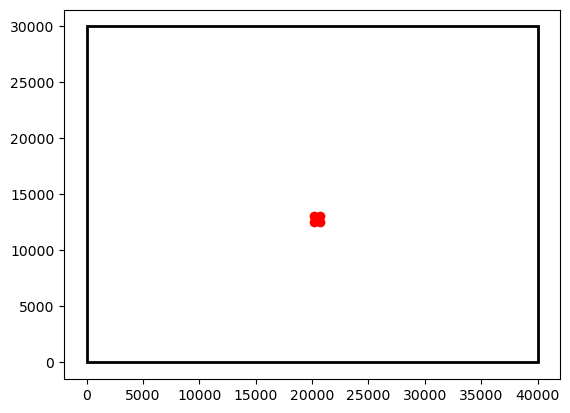

In [64]:
plt.figure()
for k in coords:
    plt.plot(k[0],k[1],'or')

plot_rectangle(config['hard-limit-x'][0],config['hard-limit-x'][1],config['hard-limit-y'][0],config['hard-limit-y'][1])


## change config limits if coords are outside of the limits

In [58]:
coords

array([[11807.65, -7893.74],
       [12307.65, -7893.74],
       [12307.65, -7393.74],
       [11807.65, -7393.74]])

In [70]:
coords

array([[11807.65, -7893.74],
       [12307.65, -7893.74],
       [12307.65, -7393.74],
       [11807.65, -7393.74]])

In [66]:
print("starting Acquisition")
results_4x = spacq.whole_slide_bf_scan(
    save_path,
    acq_name,
    coords,
    mag="4x",
    focus_dive=True,
    estimate_background=False,
)

starting Acquisition
acq_path C:\Users\lociuser\Codes\MikeN\data\test_\FirstScan2_2


  0%|          | 0/4 [00:00<?, ?it/s]

 Diving focus at -1Score: 0.012398016145821526, Position -66.67333333333333
 Diving focus at 0Score: 0.01303081892833071, Position -33.339999999999996
 Diving focus at 1Score: 0.01162174660522371, Position -0.006666666666660603


 25%|██▌       | 1/4 [00:04<00:12,  4.21s/it]

 1/4 tiles done

 50%|█████     | 2/4 [00:06<00:05,  2.83s/it]

 2/4 tiles done

 75%|███████▌  | 3/4 [00:08<00:02,  2.46s/it]

 3/4 tiles done

100%|██████████| 4/4 [00:09<00:00,  2.47s/it]

 4/4 tiles done

In [25]:

X = float(f'{xy.x+100}')
Y = float(f'{xy.y+100}')
print(X,Y)

17458.69 17049.07


In [26]:

import yaml
config = yaml.load(open("config.yaml", "r"), Loader=yaml.FullLoader)
config = {**config['user_config'], **config['model_config'], **config['hard_config']}
XLIMS = config['hard-limit-x']
YLIMS = config['hard-limit-y']

In [31]:
config_yaml_string = """
user_config:
  exposure-level : "high"
  snr-level : "low"
  autofocus-speed : 3
  lsm-resolution : 256
  lsm-bin-factor : 15
  lsm-scan-rate : "250000.0000"
  lsm-pc-power : 0.4
  lsm-pmt-gain : 0.4
  slide-box : [-100, 600, 25500.0, 17000.0] 
  lsm-enhancer : null
  bf-enhancer : null
  classifier : null
model_config:
    adv-interval: 3
    average-factor: 50
    batch-size: 8
    blindspot-rate: 0.05
    cnn-base-channel: 8
    dataset: datasets/PA_2081b
    gan-lambda: 5
    gpu: true
    image-channel: 1
    image-extension: tif
    iter-per-epoch: 200
    iterations: 200000
    learning-rate: 0.0001
    load-weights: supervised2022-08-07_13-02-52
    loss-gain: 1000
    norm-range:
    - 5420
    - 44017
    norm-range-target:
    - 6265
    - 38567
    only-pixel-loss: false
    percep-lambda: 0.5
    resolution: 512
    test-interval: 5
    threads: 0
    up-scale-factor: 2
hard_config:
    pixel-size-bf-20x : 0.222 # 0.222 micron/pixel at (1392, 1040)
    pixel-size-bf-4x : 1.105 # 1.305 micron/pixel at (1392, 1040)
    pixel-size-shg-base : 0.509 # 0.509 micron/pixel at 256
    pixel-size-shg : 0.509
    camera-resolution : [1392, 1040] # (width, height)
    lsm-resolution-base : [512, 512]
    slide-size : [40000.0, 20000.0] # (width, height) (70000, -20000)
    Z-stage-20x : -6980 # -6930 + 290 / 10500
    Z-stage-laser : -6640 #-6640 
    Z-stage-4x : 3570 # -2300
    F-stage-20x : -15800 # 11000
    F-stage-laser : -18500 # -17500
    F-stage-4x : -1000
    Z-bf-offset : -10560
    Z-laser-offset : 290
    hard-limit-z : [-8500.0, 17000.0]
    hard-limit-x : [-5000.0, 40000.0]
    hard-limit-y : [-4200, 25000.0] #(-2200, 19000.0)
    hard-limit-f : [-19000, 0]
    20x-bf-offset : [-600, 10] # 4x + this value to 20x // (-590, 74)
    shg-offset : [-580, -280] # 4x + this value to shg // (-580, -172)
    led-4x : 4
    led-20x : 5
    focus-device : 'ZStage:Z:32'
    condensor-device : 'ZStage:F:32'
    led-device : ['LED-Dev1ao0', 'Voltage']
    obj-device : ['Turret:O:35', 'Label']
"""
config_yaml = yaml.load(config_yaml_string, Loader=yaml.FullLoader)
config_yaml = {**config_yaml['user_config'], **config_yaml['model_config'], **config_yaml['hard_config']}

In [32]:
config_yaml == config


True

In [27]:
core.set_xy_position(X,Y)

In [23]:

#core.set_xy_position(X,Y)
_ = core.get_xy_stage_position()
print(_.x, _.y)

17358.69 16949.07


In [20]:
if XLIMS[0] < X < XLIMS[1]:
    pass
else:
    print(" X={X} Out of config[hard-limit-x] in yaml {XLIMS}", file=sys.stderr)
    sys.exit(1)
if YLIMS[0] < Y < YLIMS[1]:
    pass    
else:
    print(" Y={Y} Out of config[hard-limit-y] in yaml {YLIMS}", file=sys.stderr)
    sys.exit(1)
    
core.set_xy_position(X,Y)


X is within XLIMS


In [15]:
for k in config.keys():
    print(k)

exposure-level
snr-level
autofocus-speed
lsm-resolution
lsm-bin-factor
lsm-scan-rate
lsm-pc-power
lsm-pmt-gain
slide-box
lsm-enhancer
bf-enhancer
classifier
adv-interval
average-factor
batch-size
blindspot-rate
cnn-base-channel
dataset
gan-lambda
gpu
image-channel
image-extension
iter-per-epoch
iterations
learning-rate
load-weights
loss-gain
norm-range
norm-range-target
only-pixel-loss
percep-lambda
resolution
test-interval
threads
up-scale-factor
pixel-size-bf-20x
pixel-size-bf-4x
pixel-size-shg-base
pixel-size-shg
camera-resolution
lsm-resolution-base
slide-size
Z-stage-20x
Z-stage-laser
Z-stage-4x
F-stage-20x
F-stage-laser
F-stage-4x
Z-bf-offset
Z-laser-offset
hard-limit-z
hard-limit-x
hard-limit-y
hard-limit-f
20x-bf-offset
shg-offset
led-4x
led-20x
focus-device
condensor-device
led-device
obj-device


In [12]:
## config : default config only:  changed will be saved to expt folder
import yaml
## read image: background correction
from skimage import io as skio
# pos list
import pickle

In [13]:
## Config Loading
config = yaml.load(open("config.yaml", "r"), Loader=yaml.FullLoader)
config = {**config['user_config'], **config['model_config'], **config['hard_config']}
lsm_pixel_size_base = config['pixel-size-shg-base']
bf_4x_pixel_size_base = config['pixel-size-bf-4x']
bf_20x_pixel_size_base = config['pixel-size-bf-20x']
camera_resolution_base = config['camera-resolution']

In [5]:
## User configuration block
save_path = 'data/acquisition' # do not change
acq_name = 'fail_test2' # current session name No Spaces in name! Use - or _ No `ome` in name!
slide_box = [5000, 9000, 9000, 14000] # [bottom left corner, and top right corner]
brightfield_4x_background_fname = 'data/presets/BG_4x.tiff' # give a default 4x background image
brightfield_20x_background_fname = 'data/presets/BG_20x.tiff' # give a default 20x background image

In [6]:
sp_acq = SPAcquisition(
    config=config,
    mmcore=core, 
    mmstudio=studio,
    bf_4x_bg=skio.imread(brightfield_4x_background_fname), 
    bf_20x_bg=skio.imread(brightfield_20x_background_fname), 
    )

Loaded LSM presets.


In [11]:
slide_box = [25000, 16000, 28000, 20000]
sp_acq.update_slide_box(slide_box)
position_list_4x = sp_acq.generate_grid(mag='4x', overlap=50)
sp_acq.position_list_4x = position_list_4x

In [13]:
position_list_4x

array([[[25000.  , 16000.  ],
        [26482.91, 16000.  ]],

       [[26482.91, 17093.95],
        [25000.  , 17093.95]],

       [[25000.  , 18187.9 ],
        [26482.91, 18187.9 ]]])

In [14]:
position_list_4x.ndim

3

In [15]:
acq_name_4x = acq_name + '-4x-bf' 
sp_acq.switch_objective(mag='4x')
sp_acq.switch_mod(mod='bf')

Imaging objective set as 4x
Imaging objective set as 4x
Imaging mode set as Brightfield


In [16]:
sp_acq.update_focus_presets(mag='4x', mod='bf') # update focus preset
sp_acq.config['autofocus-speed'] = 4 # default is 4 ## `1-6`, the larger the faster, but potentially worse autofocusing resuls.

In [17]:
core.set_shutter_open(True)
core.set_auto_shutter(False)
core.set_shutter_open(True)

In [18]:
results_4x = sp_acq.whole_slide_bf_scan(
    save_path, 
    acq_name_4x, 
    position_list_4x.reshape(position_list_4x.shape[0]*position_list_4x.shape[1], -1), 
    mag='4x',
    focus_dive=True,
    estimate_background=False,
    )

100%|██████████| 6/6 [00:13<00:00,  2.29s/it]

 6/6 tiles done

In [19]:
stitch_folder = r'C:\Users\lociuser\Codes\smart-wsi-scanner\data\acquisition\fail_test2-4x-bf_1'
position_list = position_list_4x
pixel_size = config['pixel-size-bf-4x']

In [17]:
import os

In [28]:
position_list.shape

(4, 2, 2)

In [37]:
import numpy as np
position_list = np.reshape(position_list,[4*2,2])

In [20]:
for pos in range(position_list.shape[0]):
    #x = int(position_list[pos][0] / pixel_size)
    #y = int(position_list[pos][1] / pixel_size)
    #print('{}.tiff; ; ({}, {})'.format(pos, x, y), file=text_file)
    print(position_list[pos])

[[25000.   16000.  ]
 [26482.91 16000.  ]]
[[26482.91 17093.95]
 [25000.   17093.95]]
[[25000.   18187.9 ]
 [26482.91 18187.9 ]]


In [21]:
import glob
import pathlib
import shutil

In [22]:
for fn in glob.glob(r'C:\Users\lociuser\Codes\smart-wsi-scanner\data\acquisition\fail_test2-4x-bf_1\*.tif'):
    fname = pathlib.Path(fn).name
    nfname = fname.split('-')[0]+'.tif'
    #print(nfname)
    nfn = fn.replace(fname,nfname)
    shutil.copy(fn,nfn)

In [30]:
import os
import numpy as np

In [28]:
position_list

array([[[25000.  , 16000.  ],
        [26482.91, 16000.  ]],

       [[26482.91, 17093.95],
        [25000.  , 17093.95]],

       [[25000.  , 18187.9 ],
        [26482.91, 18187.9 ]]])

In [31]:
if position_list.ndim == 3:
    p1, p2, p3 = position_list.shape
    position_list = np.reshape(position_list, [p1 * p2, p3])

In [32]:
with open(os.path.join(stitch_folder, "TileConfiguration.txt"), "w") as text_file:
    print("dim = {}".format(2), file=text_file)
    for pos in range(position_list.shape[0]):
        x = int(position_list[pos][0] / pixel_size)
        y = int(position_list[pos][1] / pixel_size)
        print("{}.tif; ; ({}, {})".format(pos, x, y), file=text_file)

In [38]:
stitch_folder

'C:\\Users\\lociuser\\Codes\\smart-wsi-scanner\\data\\acquisition\\fail_test2-4x-bf_1'

In [41]:
image_list = glob.glob(os.path.join(stitch_folder, r'stitch\*.tif'))
if len(image_list) == 0:
    if not os.path.exists(os.path.join(stitch_folder, "stitch")):
        os.mkdir(os.path.join(stitch_folder, "stitch"))
    shutil.copy(os.path.join(stitch_folder, "TileConfiguration.txt"), os.path.join(stitch_folder, "stitch\TileConfiguration.txt"))
    for pos in range(position_list.shape[0]):
        fnx = f"{pos}.tif"
        shutil.copy(os.path.join(stitch_folder, fnx), os.path.join(stitch_folder, "stitch", fnx))
    
image_list = glob.glob(os.path.join(stitch_folder, r'stitch\*.tif'))        
print(len(image_list))

6


In [34]:
from skimage import io,  img_as_uint, transform

In [40]:
stitch_folder

'C:\\Users\\lociuser\\Codes\\smart-wsi-scanner\\data\\acquisition\\fail_test2-4x-bf_1'

In [43]:
for pos in range(len(image_list)):
        fn = image_list[pos]
        fname = pathlib.Path(fn).name

        img = io.imread(fn)

        correction = False
        rotate = False
        flip_y = True
        flip_x = False

        # if correction is True and background_image is not None:
        #    img = white_balance(img, background_image)
        #    img = flat_field(img, bg_img)

        if rotate is not None:
            img = transform.rotate(img, rotate)

        if flip_y:
            img = img[::-1, :]

        if flip_x:
            img = img[:, ::-1]
            ##TODO: replace scikit iosave with tifffile with metadata
        io.imsave(
            stitch_folder + r"/stitch/{}.tif".format(pos),
            img_as_uint(img),
            check_contrast=False,
        )